[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MNoichl/simple_teams/blob/main/team_reasoning_in_prisoners_full_replacement_replicator_dyn.ipynb)

# Team-reasoning in the Prisoners-Dilemma with replicator dynamics


This notebook implements a simulation of the PD game using mesa. In the simulation, agents, which are either team-reasoners or not, are randomly assigned other players, with whom they play the PD. The players collected utilities are then transformed into the new ratio of team reasoners, in a manner inspired by Armadae and Lempert, 2015.

In [2]:
# uncomment these lines below, when running in colab:
# !pip install nashpy==0.0.20
# !pip install mesa
# !git clone https://github.com/MNoichl/simple_teams
# %cd simple_teams


# game-theoretic:
import nashpy as nash

# mesa:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# standards:
import numpy as np
import pandas as pd
import tqdm

# graphics:
import seaborn as sns
import matplotlib.pyplot as plt

# code formatting – comment out when using colab:
%load_ext nb_black


<IPython.core.display.Javascript object>

## To-Do
1. Pairwise scheduling of agents? (Via one agent!)
1. error handling für keine Team-reasoner mehr.
1. Replicator dynamics [Leyla will tell me] 
2. Add different games 
2. Multiple games
3. Endogenize probability through bayesian learning
4. Put agents eg. on networks
5. different matrix for learning of TRs? 

In [3]:
# A = np.array([[5-3, 5-0], [5-5, 5-1]])
# B = np.array([[5-3, 5-5], [5-0, 5-1]])

A = np.array([[3, 1], [4, 2]])
B = np.array([[3, 4], [1, 2]])


prisoners_dilemma = nash.Game(A, B)

equilibria = prisoners_dilemma.support_enumeration()
for eq in equilibria: #check equilibria
    print(eq)


(array([0., 1.]), array([0., 1.]))


<IPython.core.display.Javascript object>

In [4]:
prisoners_dilemma  # [[0, 1], [1, 0]]

Bi matrix game with payoff matrices:

Row player:
[[3 1]
 [4 2]]

Column player:
[[3 4]
 [1 2]]

<IPython.core.display.Javascript object>

In [15]:
prisoners_dilemma[[0, 1], [0, 1]]

array([2, 2])

<IPython.core.display.Javascript object>

In [106]:
def random_argmax(b):  # argmax with tiebreaking.
    return np.random.choice(np.flatnonzero(b == np.max(b)))


class MyAgent(Agent):
    """ """

    def __init__(
        self, unique_id, model, team_reasoner=False, probability_team_reasoning=0.9
    ):
        super().__init__(unique_id, model)

        self.team_reasoner = team_reasoner
        self.alive = True
        self.gathered_utility = 0
        self.probability_team_reasoning = probability_team_reasoning
        self.team_reasoning_counter = 0

    def step(self):
        #         The agent's step will go here.
        other_player = self.random.choice(self.model.schedule.agents)

        #         print(self.model.game)
        choices = [
            self.reason(
                player,
                player.team_reasoner,
                player.model.game,
                player.probability_team_reasoning,
            )
            for player in [self, other_player]
        ]
        payoff = self.model.game[list(choices[0]), list(choices[1])]
        self.gathered_utility += payoff[0]
        pass

    def reason(self, player, team_reasoner, game, probability_team_reasoning):
        if team_reasoner == True:

            if np.random.rand() < probability_team_reasoning:
                #                 choice = random_argmax([0, 1])
                #                 strat = np.zeros(2)
                #                 strat[choice] = 1
                if player == self:
                    self.team_reasoning_counter += 1  # Hic sunt draconis!
                return [1, 0]
            else:
                #                 choice = random_argmax([1, 0])
                #                 strat = np.zeros(2)
                #                 strat[choice] = 1
                return [0, 1]
        else:
            #             choice = random_argmax([1, 0])
            #             strat = np.zeros(2)
            #             strat[choice] = 1
            return [0, 1]


class MyModel(Model):
    """"""

    def __init__(
        self, proportion_team_reasoners, n_agents, game, probability_team_reasoning
    ):
        super().__init__()

        self.n_agents = n_agents
        self.schedule = RandomActivation(self)
        self.game = game
        self.probability_team_reasoning = probability_team_reasoning
        self.make_n_agents(self.n_agents, proportion_team_reasoners)
        self.proportion_team_reasoners = proportion_team_reasoners

        agent_reporters = {
            "team_reasoner": lambda a: getattr(a, "team_reasoner", None),
            "gathered_utility": lambda a: getattr(a, "gathered_utility", None),
            "alive": lambda a: getattr(a, "alive", None),
            "team_reasoning_counter": lambda a: getattr(
                a, "team_reasoning_counter", None
            ),
        }

        model_reporters = {}

        self.datacollector = DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )

    def make_n_agents(self, n_agents, proportion_team_reasoners, starting_no=0):

        team_reason_until = int(proportion_team_reasoners * n_agents)
        for ix, i in enumerate(range(self.n_agents)):
            if ix < team_reason_until:
                a = MyAgent(
                    unique_id=i + starting_no,
                    model=self,
                    team_reasoner=True,
                    probability_team_reasoning=self.probability_team_reasoning,
                )
            else:
                a = MyAgent(
                    unique_id=i + starting_no,
                    model=self,
                    team_reasoner=False,
                    probability_team_reasoning=self.probability_team_reasoning,
                )

            self.schedule.add(a)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

        replication_frame = pd.DataFrame(
            [
                [agent.gathered_utility for agent in model.schedule.agents],
                [agent.team_reasoner for agent in model.schedule.agents],
            ]
        ).T
        replication_frame.columns = ["gathered_utility", "team_reasoner"]
        #         display(replication_frame)
        # average vs. expected utility
        ratio_dict = dict(
            pd.to_numeric(replication_frame["gathered_utility"])
            .groupby(replication_frame["team_reasoner"])
            .mean()
        )

        non_tr_utils = ratio_dict.get(False)
        tr_utils = ratio_dict.get(True)

        #         non_tr_utils = (
        #             1 - self.proportion_team_reasoners
        #         ) * 2 + self.proportion_team_reasoners * 4  # change to nash
        #         tr_utils = (
        #             1 - self.proportion_team_reasoners
        #         ) * 1 + self.proportion_team_reasoners * 3  # change to nash

        #         average_utility = pd.to_numeric(replication_frame["gathered_utility"]).mean()

        delta_share = (
            self.proportion_team_reasoners
            * (1 - self.proportion_team_reasoners)
            * (
                (non_tr_utils - tr_utils)
                / (
                    (self.proportion_team_reasoners * tr_utils)
                    + ((1 - self.proportion_team_reasoners) * non_tr_utils)
                )
            )
        )

        new_tr_share = self.proportion_team_reasoners - delta_share

        max_id = np.max([agent.unique_id for agent in model.schedule.agents])

        for agent in model.schedule.agents:
            self.schedule.remove(agent)

        self.make_n_agents(self.n_agents, new_tr_share, max_id + 1)
        self.proportion_team_reasoner = new_tr_share


model = MyModel(
    proportion_team_reasoners=0.6,
    n_agents=300,
    game=prisoners_dilemma,
    probability_team_reasoning=0.5,
)

for t in tqdm.tqdm_notebook(range(100)):
    model.step()

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:171: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [107]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

<IPython.core.display.Javascript object>

In [108]:
agent_df = agent_df.reset_index()

<IPython.core.display.Javascript object>

In [109]:
agent_df

,Step,AgentID,team_reasoner,gathered_utility,alive,team_reasoning_counter
0,1,0,True,3,True,1
1,1,1,True,1,True,1
2,1,2,True,3,True,1
3,1,3,True,3,True,1
4,1,4,True,4,True,0
...,...,...,...,...,...,...
29995,100,29995,False,2,True,0
29996,100,29996,False,2,True,0
29997,100,29997,False,4,True,0
29998,100,29998,False,2,True,0


<IPython.core.display.Javascript object>

Text(0.0, 1.0, 'Fraction of team-reasoners over 100 iterations of Prisoners Dilemma')

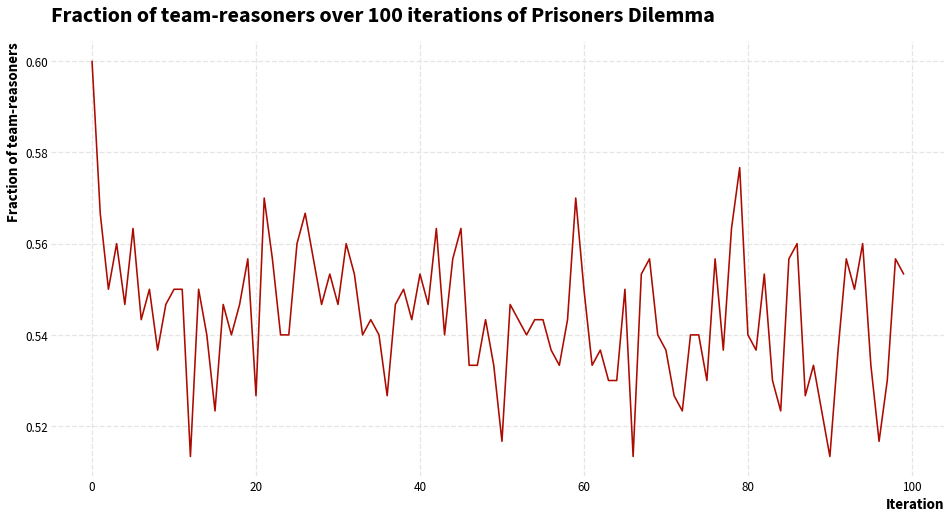

<IPython.core.display.Javascript object>

In [110]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use("opinions.mplstyle")

total_amount_of_agents = agent_df.groupby("Step")["alive"].sum()
total_amount_of_team_reasoners = agent_df.groupby("Step")["team_reasoner"].sum()

plt.plot(
    [y / x for x, y in zip(total_amount_of_agents, total_amount_of_team_reasoners)],
    linewidth=1.6,
    c="#ab0b00",
    alpha=1,
)

plt.xlabel("Iteration")
plt.ylabel("Fraction of team-reasoners")
plt.title(
    "Fraction of team-reasoners over "
    + str(np.max(agent_df["Step"]))
    + " iterations of Prisoners Dilemma"
)

In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(8, 8))
# plt.style.use("opinions.mplstyle")

# to_plot = agent_df[agent_df["Step"] == np.max(agent_df["Step"])]

# # Plot the orbital period with horizontal boxes
# sns.boxplot(
#     x="team_reasoner",
#     y="gathered_utility",
#     data=to_plot,
#     whis=[0, 100],
#     width=0.6,
#     palette=["#1a2340", "#f2ad00"],
# )

# # Add in points to show each observation
# sns.stripplot(
#     x="team_reasoner",
#     y="gathered_utility",
#     size=5,
#     data=to_plot,
#     color="black",
#     linewidth=0,
#     alpha=0.5,
# )

# plt.xlabel("Team-reasoner")
# plt.ylabel("Utility")
# plt.title("Collected utility after " + str(np.max(agent_df["Step"])) + " iterations")

<IPython.core.display.Javascript object>

In [13]:
# # to_plot
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.style.use("opinions.mplstyle")

# sns.scatterplot(
#     x=to_plot["gathered_utility"],
#     y=to_plot["team_reasoning_counter"],
#     hue=to_plot["team_reasoner"],
#     palette=["#1a2340", "#f2ad00"],
# )

# plt.title("Collected utility depending on actually played team-reasoning")
# plt.ylabel("Count of actually played team-reasoning")
# plt.xlabel("Utility")

<IPython.core.display.Javascript object>

# Varying parameters

In [111]:
collected_results = []
run_no = 0
for proportion_of_team_reasoners in tqdm.tqdm_notebook(np.linspace(0.05, 0.95, 11)):
    for probability_team_reasoning in tqdm.tqdm_notebook(np.linspace(0, 1, 11)):

        model = MyModel(
            proportion_team_reasoners=proportion_of_team_reasoners,
            n_agents=200,
            game=prisoners_dilemma,
            probability_team_reasoning=probability_team_reasoning,
        )

        for t in range(10):
            try:
                model.step()
            except:
                break
        model_df = model.datacollector.get_model_vars_dataframe()
        agent_df = model.datacollector.get_agent_vars_dataframe()
        agent_df = agent_df.reset_index()

        agent_df["run_no"] = run_no
        agent_df["proportion_team_reasoners"] = proportion_of_team_reasoners
        agent_df["probability_team_reasoning"] = probability_team_reasoning

        collected_results.append(
            agent_df
        )  # this is not memory-friendly in the long run...
        run_no += 1

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [112]:
collected_frame = pd.concat(collected_results)

<IPython.core.display.Javascript object>

In [113]:
grouped = collected_frame.groupby(["run_no", "team_reasoner"])[
    "gathered_utility"
].sum()
grouped = pd.DataFrame(grouped).reset_index()
display(grouped)
grouped = grouped.groupby("run_no")

diff_frames = []
for name, group in grouped:
    diff_frame =  pd.DataFrame(collected_frame[collected_frame["run_no"] == name].iloc[0]).T[
            ["run_no", "proportion_team_reasoners", "probability_team_reasoning"]
        ]
    performance_diff = (
        group[group["team_reasoner"] == False]["gathered_utility"].iloc[0]
        - group[group["team_reasoner"] == True]["gathered_utility"].iloc[0]
    )
    diff_frame['performance_diff'] = performance_diff
    
    diff_frame['amount_of_steps'] = np.max(collected_frame[collected_frame["run_no"] == name]['Step'])
    run_frame = pd.DataFrame(collected_frame[collected_frame["run_no"] == name])
    final_step = run_frame[run_frame['Step'] == 9]
    share_tr = len(final_step[final_step['team_reasoner'] ==True])
    print(share_tr)
    diff_frame['final_tr_share'] = share_tr

    
#     print( pd.DataFragroup[group["team_reasoner"] == False].shape)
#     
#     share = (
#         len(group[group["team_reasoner"] == False]),len(group[group["team_reasoner"] == True])
#     )
#     print(share)
#     display(pd.DataFrame(collected_frame[collected_frame["run_no"] == name].iloc[len(group)]))

    diff_frames.append(diff_frame)


,run_no,team_reasoner,gathered_utility
0,0,False,3800
1,0,True,200
2,1,False,3826
3,1,True,180
4,2,False,3858
...,...,...,...
237,118,True,4911
238,119,False,488
239,119,True,5193
240,120,False,530


10
9
8
8
9
6
6
6
6
5
5
28
25
24
23
22
21
23
18
21
15
18
46
44
43
42
37
33
36
33
32
32
31
64
61
58
60
61
51
53
52
47
45
39
82
79
80
69
70
73
70
64
64
65
57
99
99
94
89
86
86
87
91
79
82
78
118
114
111
114
106
104
105
102
100
101
103
136
132
133
126
126
132
121
119
122
121
115
154
151
150
150
146
146
145
145
142
142
138
172
173
171
170
169
167
166
164
163
162
163
190
188
190
189
186
187
187
187
186
187
186


<IPython.core.display.Javascript object>

In [114]:
difference_frame = pd.concat(diff_frames)

<IPython.core.display.Javascript object>

In [115]:
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate

<IPython.core.display.Javascript object>

In [116]:
difference_frame

,run_no,proportion_team_reasoners,probability_team_reasoning,performance_diff,amount_of_steps,final_tr_share
0,0,0.05,0,3600,10,10
0,1,0.05,0.1,3646,10,9
0,2,0.05,0.2,3698,10,8
0,3,0.05,0.3,3727,10,8
0,4,0.05,0.4,3757,10,9
...,...,...,...,...,...,...
0,116,0.95,0.6,-4306,10,187
0,117,0.95,0.7,-4482,10,187
0,118,0.95,0.8,-4447,10,186
0,119,0.95,0.9,-4705,10,187


<IPython.core.display.Javascript object>

Text(0.5, 0, 'Mean utility: non-TR - TR')

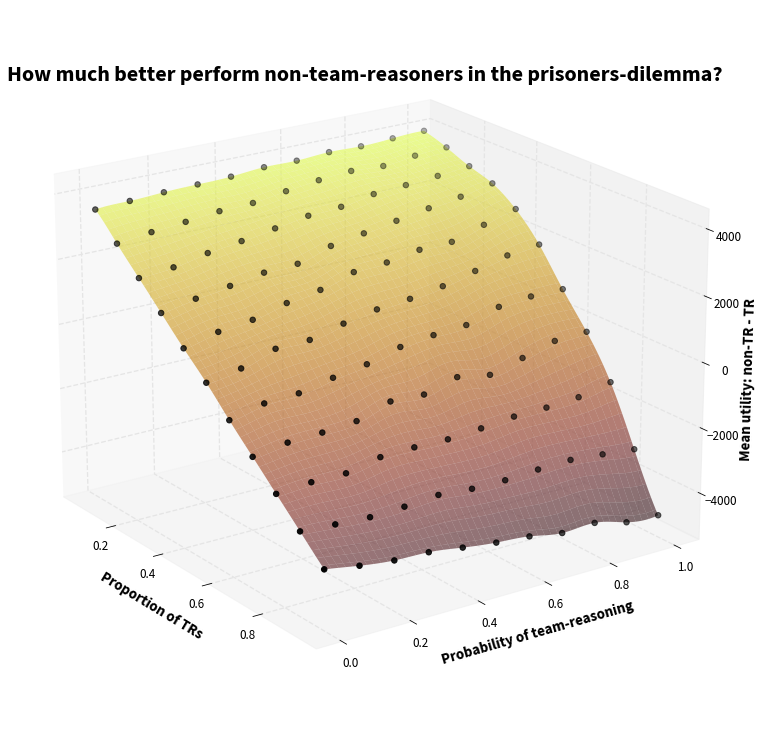

<IPython.core.display.Javascript object>

In [117]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,-35)

import cmocean


spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["performance_diff"],function='multiquadric')#,smooth=1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]), np.max(difference_frame["proportion_team_reasoners"]),100)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]), np.max(difference_frame["probability_team_reasoning"]),100)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)

ax.plot_surface(B1, B2, Z,alpha=.6,cmap=cmocean.cm.solar)
ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["performance_diff"],
    s=30,c='black'#,alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Mean utility: non-TR - TR")
# ax.invert_xaxis()



Text(0.5, 0, 'Final number of TRs')

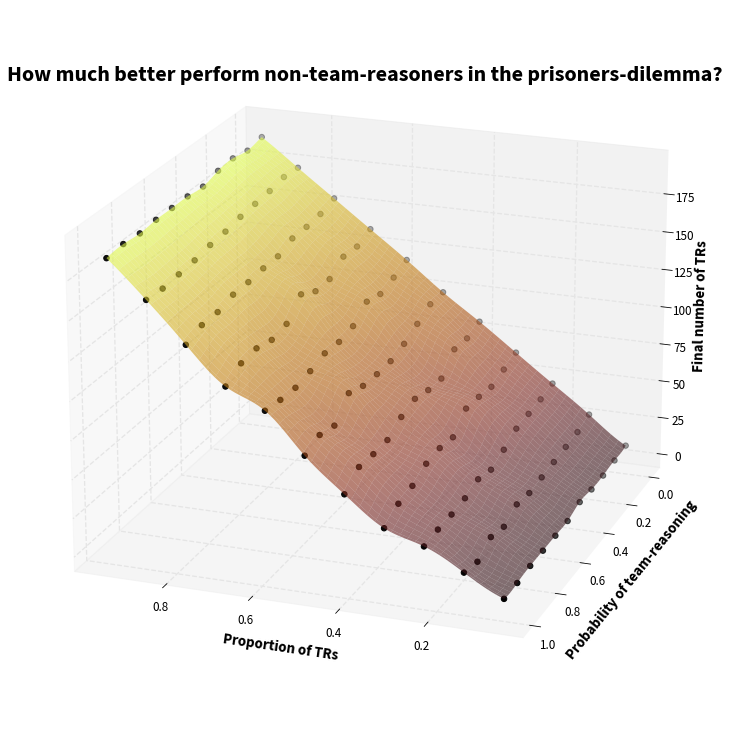

<IPython.core.display.Javascript object>

In [118]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,110)

import cmocean


spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["final_tr_share"],function='multiquadric')#,smooth=1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]), np.max(difference_frame["proportion_team_reasoners"]),100)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]), np.max(difference_frame["probability_team_reasoning"]),100)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)

ax.plot_surface(B1, B2, Z,alpha=.6,cmap=cmocean.cm.solar)
ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["final_tr_share"],
    s=30,c='black'#,alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Final number of TRs")
# ax.invert_xaxis()



Text(0.5, 0, 'Length of simulation')

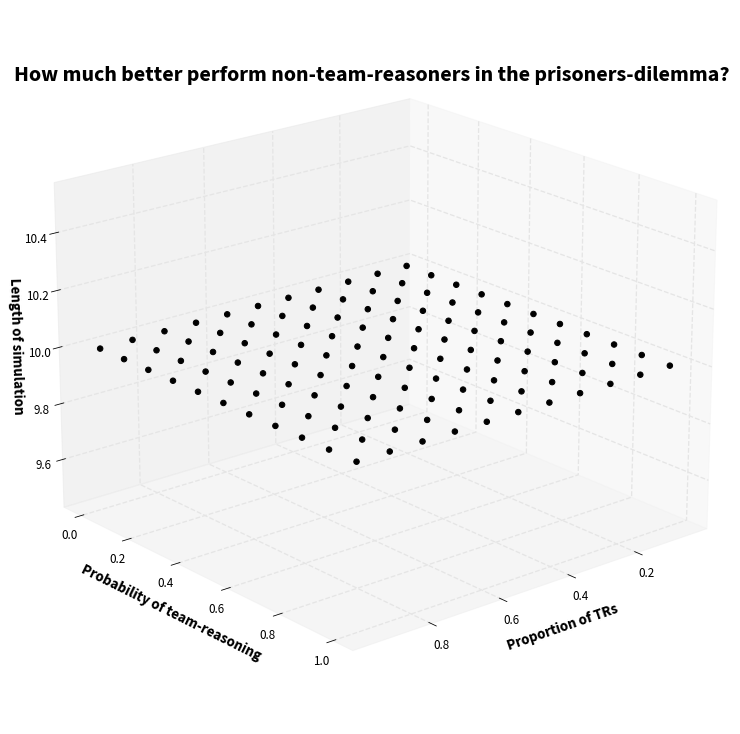

<IPython.core.display.Javascript object>

In [119]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,50)

import cmocean


spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["amount_of_steps"])#,function='multiquadric',smooth=.1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]),
                     np.max(difference_frame["proportion_team_reasoners"]),21)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]),
                     np.max(difference_frame["probability_team_reasoning"]),21)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)
# print(Z)

# ax.plot_surface(B1, B2, Z,alpha=.6,cmap=cmocean.cm.solar)
# ax.plot_wireframe(difference_frame["proportion_team_reasoners"],
#                 difference_frame["probability_team_reasoning"],
#                   ,alpha=.6,cmap=cmocean.cm.solar)


ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["amount_of_steps"],
    s=30,c='black',alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Length of simulation")
# ax.invert_xaxis()



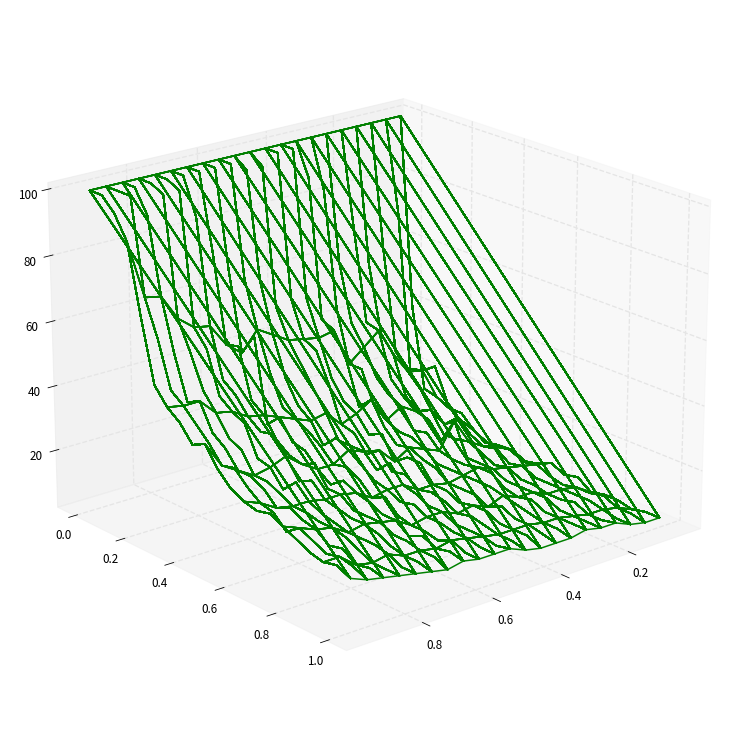

<IPython.core.display.Javascript object>

In [127]:
from scipy.interpolate import griddata

fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20, 50)
x = difference_frame["proportion_team_reasoners"]
y = difference_frame["probability_team_reasoning"]
z = difference_frame["amount_of_steps"]

X, Y = np.meshgrid(x, y)
Z = griddata((x, y), z, (X, Y), method="nearest")


ax.plot_wireframe(X, Y, Z, color="green")

plt.show()